In [46]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pygame

from typing import (
    Tuple,
    Dict,
    Optional,
    Iterable
)
from matplotlib import (
    animation
)
from gym import (
    spaces
)
from gym.error import (
    DependencyNotInstalled
)
from pygame import (
    gfxdraw
)
from IPython.display import (
    HTML
)

class Maze(gym.Env):
    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal  = (size - 1, size - 1)
        self.maze  = self.__create_maze__(size=size)
        self.distances = self.__compute_distance__(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {
            0: 'UP',
            1: 'RIGHT',
            2: 'DOWN',
            3: 'LEFT'
        }
        self.observation_space = spaces.MultiDiscrete([size, size])
        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self.__get_next_state__(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info
    
    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode="human") -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))

        for row in range(5):
            for col in range(5):
                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:
                        #
                        # Add the geometry of the edges and walls (i.e. the boundaries between adjacent squares that are not connected)
                        #
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff < 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)
                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))
        
        # Add the geometry of the goal square to the viewer
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer
        agent_row = int(screen_size - scale * (self.state[0] + 0.5))
        agent_col = int(scale * (self.state[1] + 0.5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * 0.6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
            np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self.__get_next_state__(state, action)

        if self.shaped_rewards:
            return -(self.distances[next_state] / self.distances.max())
        return -float(state != self.goal)
    
    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self.__get_next_state__(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def __get_next_state__(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError('Action value not supported: ', action)
        
        if next_state in self.maze[state]:
            return next_state
        
        return state


    @staticmethod
    def __create_maze__(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {
            (row, col) : [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
            for row in range(size) 
            for col in range(size)
        }

        left_edges = [
            [(row, 0), (row, -1)] 
            for row in range(size)
        ]

        right_edges = [
            [(row, size - 1), (row, size)] 
            for row in range(size)
        ]

        upper_edges = [
            [(0, col), (-1, col)] 
            for col in range(size)
        ]

        lower_edges = [
            [(size - 1, col), (size, col)] 
            for col in range(size)
        ]

        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def __compute_distance__(goal: Tuple[int, int], maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.0

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        
        return distances
    
    def display_video(self, frames):
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        matplotlib.use(orig_backend)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])

        def update(frame):
            im.set_data(frame)
            return [im]
        
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames, interval=50, blit=True, repeat=False)

        return HTML(anim.to_html5_video())
            

In [47]:
env = Maze()

In [48]:
initial_state = env.reset()
initial_state

(0, 0)

In [49]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f'State : {initial_state}')
plt.imshow(frame)

In [50]:
action = 2
next_state, reward, done, info = env.step(action)
print(f'After moving down 1 row, the agent is in state: {next_state}')
print(f'After moving down 1 row, we got a reward of: {reward}')
print(f'After moving down 1 row, the task is', '' if done else 'not', 'finished')

After moving down 1 row, the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row, the task is not finished


In [51]:
env.close()

### Maze environment: Find the exit.

In [52]:
# Create the environment
env = Maze()

In [53]:
# State and State space

# The states consist of a tuple of two integers, both in the range [0, 4],
# representing the row and col in which the agent is currently located:
#
# s = (row, col), row, col in {0,1,2,3,4}

# The state space is the set of all posible states in the task, it has total
# 25 elements, all possible combinations of rows and columns
#
# rows x cols : S = {(0,0), (0,1), (1, 0), ...}

# Information about the state space is stored in the env.observation_space property.
# In this environment, it is of MultiDiscrete([5,5]) type, which means that it
# consists of two elements (rows and cols), each with 5 different values.

print(f'For example, the initial state is: {env.reset()}')
print(f'The space state is of type: {env.observation_space}')


For example, the initial state is: (0, 0)
The space state is of type: MultiDiscrete([5 5])


In [54]:
# Action and Action space

# In this environment, there are four different actions and they are 
# represented by integers:
#
# a in {0, 1, 2, 3}

# 0 : move up
# 1 : move right
# 2 : move down
# 3 : move left

# To execute an action, simply pass it as an argument to the env.step method.
# Information about the action space is stored in the env.action_space property
# which is of Discrete(4) class. This means that in this case it only consists 
# of an element in the range [0,4), unlike the state space seen above.

print(f'An example of a valid action is: {env.action_space.sample()}')
print(f'The action state is of type: {env.action_space}')

An example of a valid action is: 2
The action state is of type: Discrete(4)


In [55]:
# Trajectories 

# A trajectory is the sequence generated by moving from one state to another 
# (both arbitrary)
#
# t = S0,A0,R1,S1,A1,...RN,SN

# Let's generate a trajectory of 3 moves in code:

env = Maze()
state = env.reset()
trajectory = []

for _ in range(3):
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    trajectory.append([state, action, reward, done, next_state])
    state = next_state
env.close()

print(f'Congrats! You just generated your first trajectory: \n{trajectory}')

Congrats! You just generated your first trajectory: 
[[(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)]]


In [56]:
# Episodes

# An episode is a trajectory that goes from the initial state of the process to 
# the final one:
#
# t = S0,A0,R1,S1,A1,...RT,ST
# where T is the terminal state

# Let's generate a whole episode in code:

env = Maze()
state = env.reset()
episode = []
done = False

while not done:
    action = env.action_space.sample()
    next_state, reward, done, extra_info = env.step(action)
    episode.append([state, action, reward, done, next_state])
    state = next_state

env.close()

print(f'Congrats! You just generated your first episode:\n{episode}')

Congrats! You just generated your first episode:
[[(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 0, -1.0, False, (0, 0)], [(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 3, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 0, -1.0, False, (0, 0)], [(0, 0), 1, -1.0, False, (0, 1)], [(0, 1), 1, -1.0, False, (0, 2)], [(0, 2), 3, -1.0, False, (0, 1)], [(0, 1), 1, -1.0, False, (0, 2)], [(0, 2), 3, -1.0, False, (0, 1)], [(0, 1), 2, -1.0, False, (1, 1)], [(1, 1), 3, -1.0, False, (1, 1)], [(1, 1), 0, -1.0, False, (0, 1)], [(0, 1), 0, -1.0, False, (0, 1)], [(0, 1), 1, -1.0, False, (0, 2)], [(0, 2), 1, -1.0, False, (0, 3)], [(0, 3), 3, -1.0, False, (0, 2)], [(0, 2), 3, -1.0, False, (0, 1)], [(0, 1), 3, -1.0, False, (0, 0)], [(0, 0), 0, -1.0, False, (0, 0)], [(0, 0), 2, -1.0, False, (1, 0)], [(1, 0), 1, -1.0, False, (1, 0)], [(1, 0), 2, -1.0, False, (2, 0)], [(2, 0), 2, -1.0, False, (3, 0)], [(3, 0), 1, -1.0, False, (3, 0)], [(3, 0), 2, -1.0, False, (4, 0)]

In [57]:
# Reward

# A reward is numerical feedback hat the environnment generates when the agent
# takes an action a in a state s:
#
# r = r(s,a)

# Let's generate a reward from the environment:

env = Maze()
state = env.reset()
action = env.action_space.sample()
_, reward, _, _ = env.step(action)
print(f'We archived a reward of {reward} by taking action {action} in state {state}')

We archived a reward of -1.0 by taking action 3 in state (0, 0)


In [58]:
# Return

# The return associated with a moment in time t is the sum (discounted) of rewards
# that the agent obtains from that moment. We are going to calculate G0, that is,
# thet return to the beginning of the episode:
#
# G0 = R1 + gmR2 + gm^2R3 + ... + gm^{T-1}RT

# Let's assume that the discount factor gm = 0.99
#

env = Maze()
state = env.reset()
done = False
gamma = 0.99
G_0 = 0  
t = 0

while not done:
    action = env.action_space.sample()
    _, reward, done, _ = env.step(action)
    G_0 += gamma ** t * reward
    t += 1

env.close()

print(f'It took us {t} moves to find the exit, and each reward r(s,a)=-1, so the return amonts to {G_0}')

It took us 504 moves to find the exit, and each reward r(s,a)=-1, so the return amonts to -99.36884202056835


In [59]:
# Policy

# A policy is a function pi(a|s) in [0,1] that gives the probability of an action
# given the current state. The function takes the state and action as inputs and
# returns a float in [0,1].as_integer_ratio

# Since in practice we will need to compute the probabilies of all actions, we will
# represent the policy as a function that takes the state as an argument and returns
# the probabilities associated with each of the actions. Thus, of the probabilities
# are:
#
# [0.5, 0.4, 0.1]

# We will understand that the action with index 0 has 50% probability of chosen, the
# one with index 1 has 40% and the one with index 2 has 10%.

# Let's code a policy function that chooses actions randomly:



def random_policy(state, number_of_actions=4):
    return np.ones(number_of_actions) / number_of_actions

### Playing an episode with our random policy

In [60]:
env = Maze()
state = env.reset()

action_probs = random_policy(state)
action_probs

array([0.25, 0.25, 0.25, 0.25])

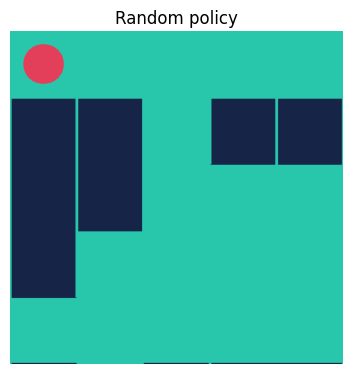

In [61]:
objects = ('Up', 'Right', 'Down', 'Left')

y_pos = np.arange(len(objects))

plt.bar(y_pos, action_probs, alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('P(a|s)')
plt.title('Random policy')
plt.tight_layout()

plt.show()

In [62]:
# Use the policy to play an episode 

def test_agent(env, policy):
    frames = []
    state = env.reset()
    done = False
    frames.append(env.render(mode='rgb_array'))

    while not done:
        action_probs = policy(state)
        action = np.random.choice(range(4), 1, p=action_probs)
        next_state, reward, done, extra_info = env.step(action)
        img = env.render(mode='rgb_array')
        frames.append(img)
        state = next_state

    return env.display_video(frames)

In [64]:
import matplotlib.animation as animation
print(animation.writers.list())


['pillow', 'html']


In [67]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

mpl.rcParams['animation.ffmpeg_path'] = r'C:\ProgramData\chocolatey\lib\ffmpeg\tools\ffmpeg\bin\ffmpeg.exe'  # Đổi thành đường dẫn FFmpeg của bạn


In [68]:
import matplotlib.animation as animation
print(animation.FFMpegWriter.isAvailable())


True


In [70]:
env = Maze()

test_agent(env, random_policy)